Lien vers la description des colonnes : https://www.kaggle.com/competitions/big-data-derby-2022/data

In [ ]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
from glob import glob
import pickle
import regex as re
from zipfile import ZipFile

import random
import math
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
mms = MinMaxScaler()

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from geopy.distance import geodesic
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 100

In [ ]:
zip_data = ZipFile("/drive/MyDrive/Projet compétition Kaggle/data/big-data-derby-2022.zip")

In [ ]:
zip_data.filelist

[<ZipInfo filename='nyra_2019_complete.csv' compress_type=deflate file_size=612401883 compress_size=99530299>,
 <ZipInfo filename='nyra_race_table.csv' compress_type=deflate file_size=94808 compress_size=17114>,
 <ZipInfo filename='nyra_start_table.csv' compress_type=deflate file_size=679661 compress_size=108644>,
 <ZipInfo filename='nyra_tracking_table.csv' compress_type=deflate file_size=336321175 compress_size=94435952>]

In [ ]:
# Chargement du jeu de données complet 
df_complete = pd.read_csv(zip_data.open("nyra_2019_complete.csv"))

df_complete["race_id"] = df_complete.groupby(["track_id", "race_date", "race_number"]).ngroup()
df_complete["ID"] = df_complete.groupby(["track_id", "race_date", "race_number", "program_number"]).ngroup()

df_complete.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,race_id,ID
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090,8,61


In [ ]:
# Calcul d'une distance entre deux points dans un repère latitude/longitude par l'approche du grand cercle
def gcd_vec(lat1, lng1, lat2, lng2):
    '''
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    '''
    # python2 users will have to use ascii identifiers
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)

    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)

    cos = (np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) +
           np.cos(ϕ1) * np.cos(ϕ2))
    arc = np.arccos(cos)

    return 1000 * arc * 6373

# Calcul de l'orientation à partir deux points dans un repère latitude/longitude 
def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)

    return brng % 180

# Mise en format conventionnel : xx min xx sec xx ms
def str_time(secs):

  mins = int(secs // 60) 
  secs = secs % 60
  ms = secs * 1000 - int(secs) * 1000
  secs = int(secs)
  ms = int(ms)

  str_time = bool(mins) * "{} min".format(mins) 
  str_time += bool(secs) * " {} s".format(secs)
  str_time += bool(ms) * " {} ms".format(ms)

  if str_time == "":
    
    return "0 s"

  return str_time.strip()

def scale(scaler, tab):

  if type(tab).__name__ == "Series":
    
    return scaler.fit_transform(tab.to_frame())

  return scaler.fit_transform(tab)

# Filtre de lissage de fonctions discontinues
def smooth(y, box):

  box = np.ones(box) / box
  
  return np.convolve(y, box, mode = "same")

def get_savgol_filter(y, deg, box):

  return savgol_filter(y, window_length = box, polyorder = deg, mode = "nearest")

In [ ]:
data = df_complete.copy()

# Conversion en secondes, 0.25 seconde d'intervalle entre deux recensements de données selon la documentation du projet
data["secondes"] = (data.trakus_index - 1) * .25 

# Format conventionnel de temps
data["temps"] = data.secondes.map(str_time)

# Association d'un ID unique à chaque course et chaque jockey dans une course
data["race_id"] = data.groupby(["track_id", "race_date", "race_number"]).ngroup()
data["ID"] = data.groupby(["track_id", "race_date", "race_number", "program_number"]).ngroup()

data.sort_values(by = ["race_id", "ID", "trakus_index"], inplace = True)

# Nombre total de recensements par jockey dans chaque course
data["nb_trakus_ids"] = data.groupby("ID").trakus_index.transform("nunique")

# Nombre total maximal de recensements identifiés dans chaque course
data["nb_max_trakus"] = data.groupby("race_id").nb_trakus_ids.transform("max")

# Nombre de jockeys présents lors de chaque course
data["nb_jockeys_at_race"] = data.groupby("race_id").jockey.transform("nunique")

# Calcul du centre de la piste dans laquelle s'est déroulée la course (approximé)
data[["lat_track_center", "long_track_center"]] = data.groupby(["track_id", "distance_id",	"course_type", "track_condition", "race_type"])[["latitude", "longitude"]].transform("mean")
data["centre_pos_concat"] = data.set_index(["lat_track_center", "long_track_center", "latitude", "longitude"]).index.tolist()

# Position du jockey au temps t-1
data[["latitude_0", "longitude_0"]] = data.groupby("ID")[["latitude", "longitude"]].transform(lambda s: s.shift(1, fill_value = s.iloc[0]))
data["P0_P1_coords"] = data.set_index(["latitude_0", "longitude_0", "latitude", "longitude"]).index.tolist()

# Calcul de la distance du jockey par rapport au centre de la piste
data["distance_from_center_m"] = data.centre_pos_concat.map(lambda v: gcd_vec(*v)).round(3)

# Calcul de l'orientation du jockey sur la piste à chaque position
data["angle_deg"] = data.P0_P1_coords.map(lambda v: get_bearing(*v)).round(3)

# Calcul de la distance totale parcourue par chaque jockey à chaque position
data["distance_parcourue_m"] = data.P0_P1_coords.map(lambda v: gcd_vec(*v)).round(3)

# Calcul de la vitesse instantanée de chaque jockey à chaque position
data["vitesse_kmh"] = (3.6 * data.distance_parcourue_m / .25).round(1).round(3)
data.distance_parcourue_m = data.groupby("ID").distance_parcourue_m.transform("cumsum")

data["zero"] = 0

# Dérivée de la distance parcourue par rapport au centre
data["derivee_distance_from_center"] = data.distance_from_center_m - data.groupby("ID").distance_from_center_m.transform(pd.Series.shift)
data["derivee_distance_from_center"] /= data.secondes - data.groupby("ID").secondes.transform(pd.Series.shift)

# Dérivée seconde de la distance parcourue par rapport au centre
data["derivee_sec_distance_from_center"] = data.derivee_distance_from_center - data.groupby("ID").derivee_distance_from_center.transform(pd.Series.shift)
data["derivee_sec_distance_from_center"] /= data.secondes - data.groupby("ID").secondes.transform(pd.Series.shift)

# Signe de la dérivée seconde de la distance parcourue par rapport au centre
data["signe_derivee_distance_from_center"] = data.derivee_distance_from_center / data.derivee_distance_from_center.abs()
data["signe_derivee_distance_from_center"].fillna(0, inplace = True)

# Signe de la dérivée de la distance parcourue par rapport au centre à t+1 et t-1
data["signe_apres"] = data.signe_derivee_distance_from_center + data.groupby("ID").signe_derivee_distance_from_center.transform(lambda s: s.shift(-1))
data["signe_avant"] = data.signe_derivee_distance_from_center + data.groupby("ID").signe_derivee_distance_from_center.transform(pd.Series.shift)

pickle.dump(data, open("/drive/MyDrive/Projet compétition Kaggle/data/data_500_races.pkl", "wb"))

In [ ]:
data = pickle.load(open("/drive/MyDrive/Projet compétition Kaggle/data/data_500_races.pkl", "rb"))
data.head(2)

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,secondes,temps,race_id,ID,nb_trakus_ids,nb_max_trakus,nb_jockeys_at_race,latitude_0,longitude_0,P0_P1_coords,angle_deg,distance_parcourue_m,vitesse_kmh,lat_track_center,long_track_center,centre_pos_concat,distance_from_center_m,zero,derivee_distance_from_center,derivee_sec_distance_from_center,signe_derivee_distance_from_center,signe_apres,signe_avant,vitesse_lissee
1212464,AQU,2019-01-01,1,3,1,40.669396,-73.829169,650,D,MY,36,AOC,80000,1220,118,Jose Lezcano,180,0.00,0 s,0,0,316,316,5,40.669396,-73.829169,"(40.6693959216858, -73.8291694653685, 40.66939...",0.000,0.000,0.0,40.672986,-73.829409,"(40.67264613919907, -73.82960286295726, 40.669...",363.365,0,NaN,NaN,0.0,-1.0,NaN,21.494313
1212453,AQU,2019-01-01,1,3,2,40.669400,-73.829167,650,D,MY,36,AOC,80000,1220,118,Jose Lezcano,180,0.25,250 ms,0,0,316,316,5,40.669396,-73.829169,"(40.6693959216858, -73.8291694653685, 40.66939...",29.295,0.484,7.0,40.672986,-73.829409,"(40.67264613919907, -73.82960286295726, 40.669...",362.966,0,-1.596,NaN,-1.0,-2.0,-1.0,23.011298


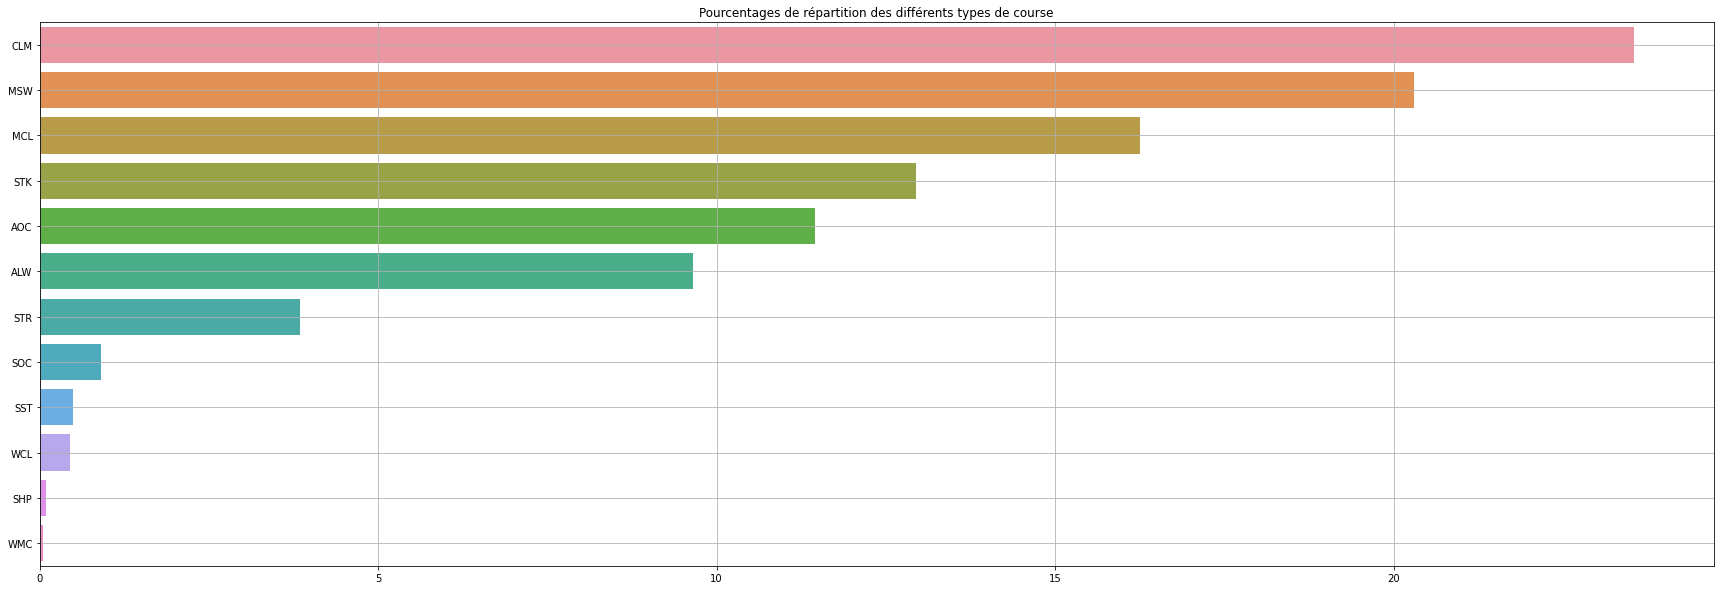

In [ ]:
series = data[data.race_id.duplicated() == False].race_type.value_counts(normalize = True) * 100

plt.figure(figsize = (30, 10))
plt.title("Pourcentages de répartition des différents types de course")
sb.barplot(x = series.values,y = series.index)
plt.grid()
plt.show()

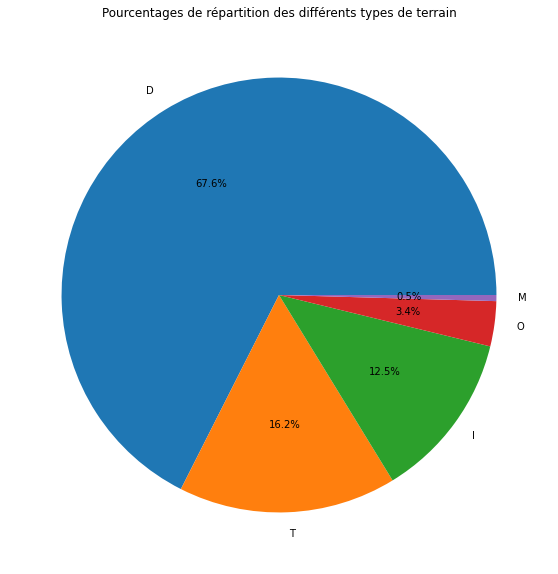

In [ ]:
series = df_complete[df_complete.race_id.duplicated() == False].course_type.value_counts(normalize = True) * 100

plt.figure(figsize = (30, 10))
plt.title("Pourcentages de répartition des différents types de terrain")
# sb.barplot(x = series.values,y = series.index)
plt.pie(series.values, labels = series.index, autopct='%1.1f%%')
plt.grid()
plt.show()

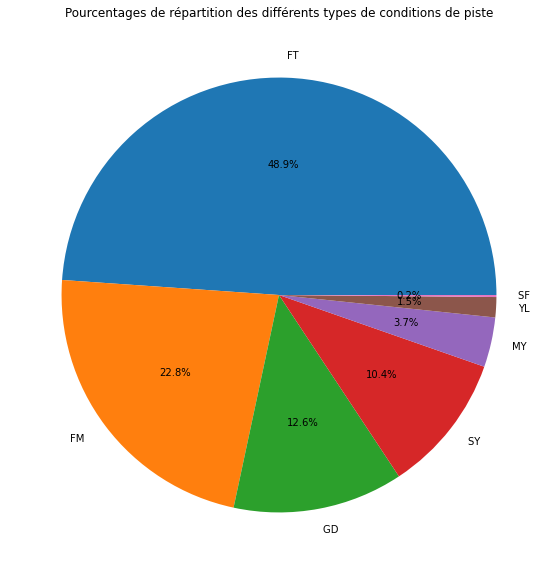

In [ ]:
series = data[data.race_id.duplicated() == False].track_condition.value_counts(normalize = True) * 100

plt.figure(figsize = (30, 10))
plt.title("Pourcentages de répartition des différents types de conditions de piste")
plt.pie(series.values, labels = series.index, autopct='%1.1f%%')
plt.grid()
plt.show()

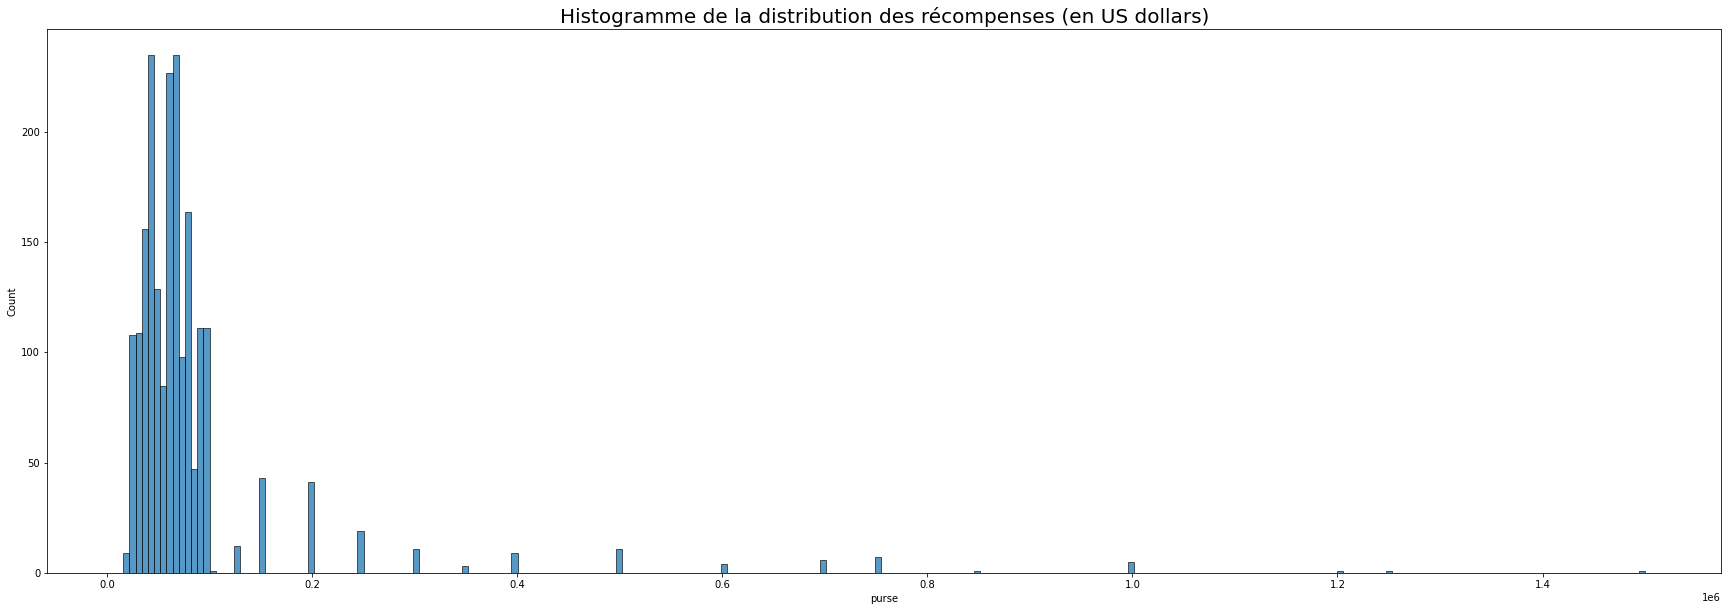

In [ ]:
plt.figure(figsize = (30, 10))
plt.title("Histogramme de la distribution des récompenses (en US dollars)", fontsize = 20)
sb.histplot(data = data[data.race_id.duplicated() == False],
           x = "purse")
plt.show()

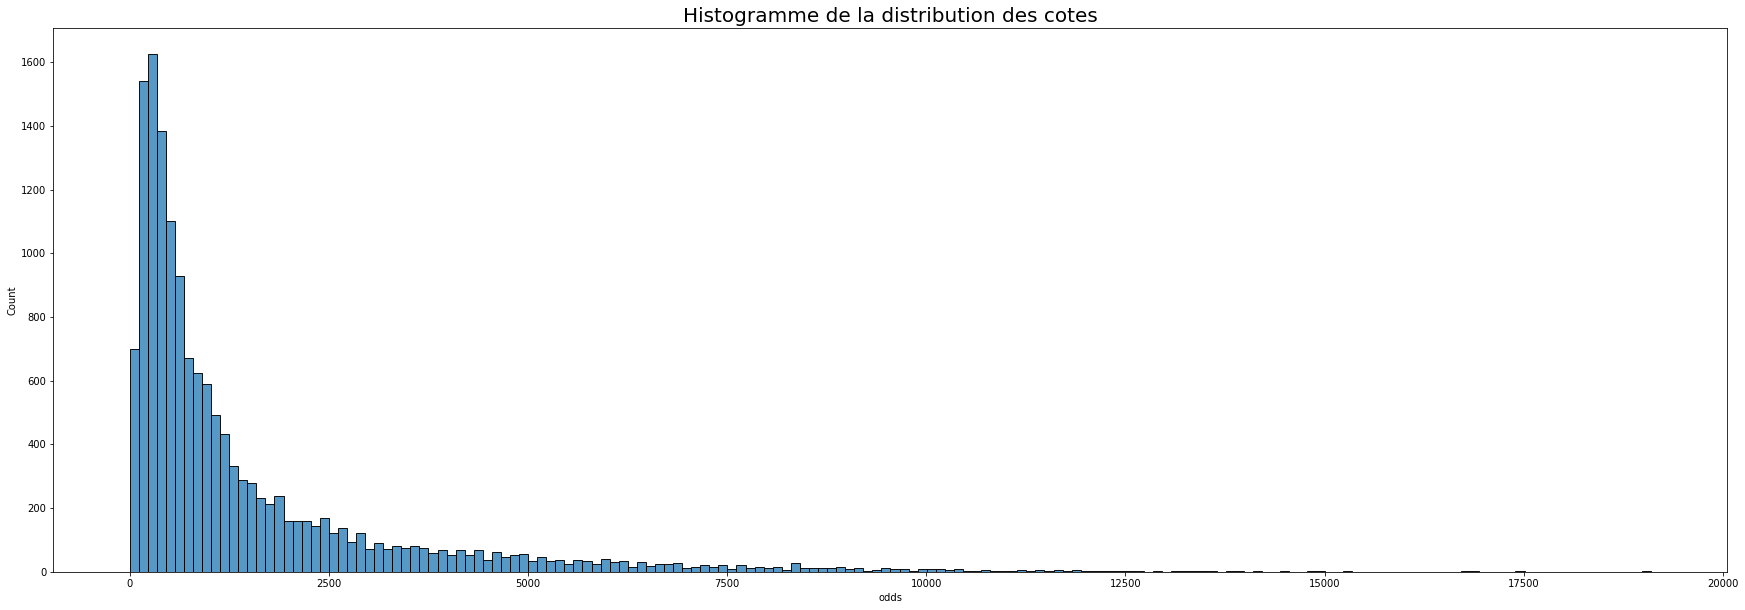

In [ ]:
plt.figure(figsize = (30, 10))
plt.title("Histogramme de la distribution des cotes", fontsize = 20)
sb.histplot(data = data[data.ID.duplicated() == False],
           x = "odds")
plt.show()

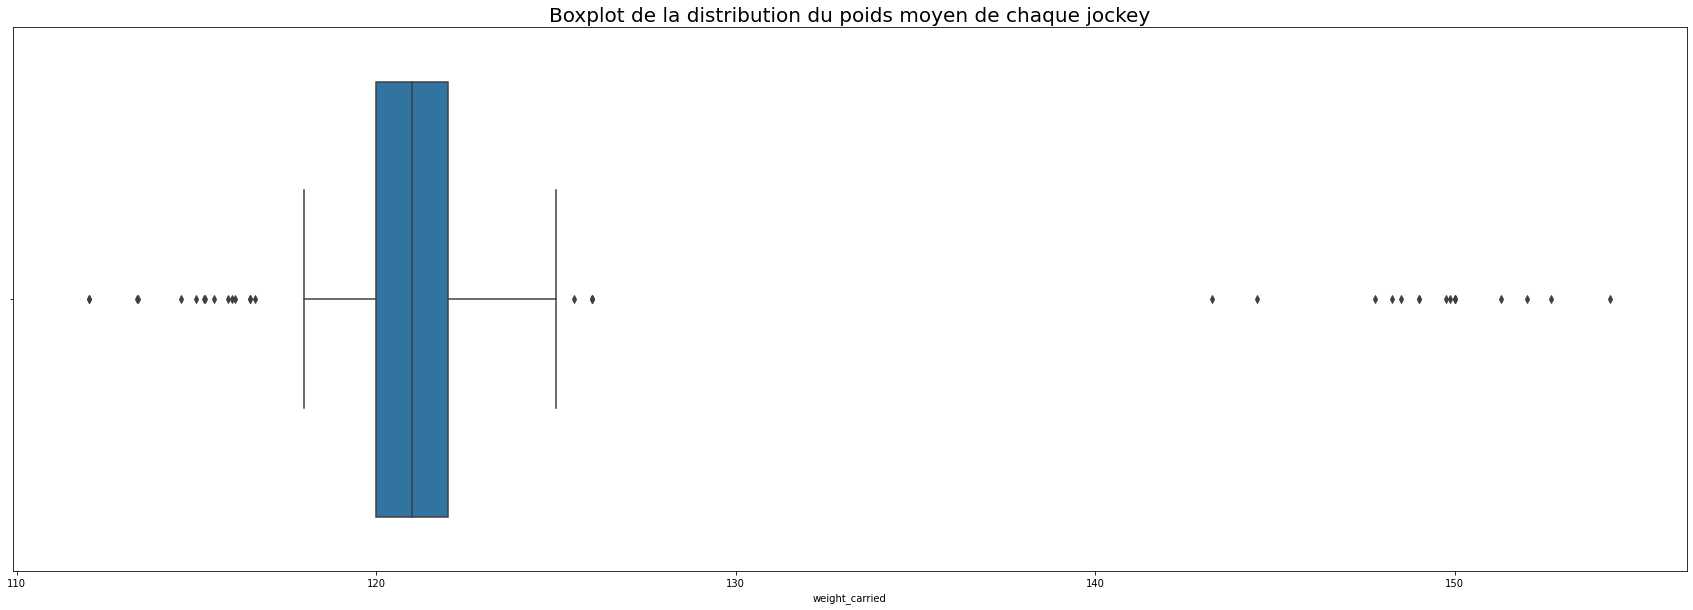

In [ ]:
plt.figure(figsize = (30, 10))
plt.title("Boxplot de la distribution du poids moyen de chaque jockey", fontsize = 20)
sb.boxplot(data = data[data.ID.duplicated() == False].groupby("jockey").mean(),
           x = "weight_carried")
plt.show()

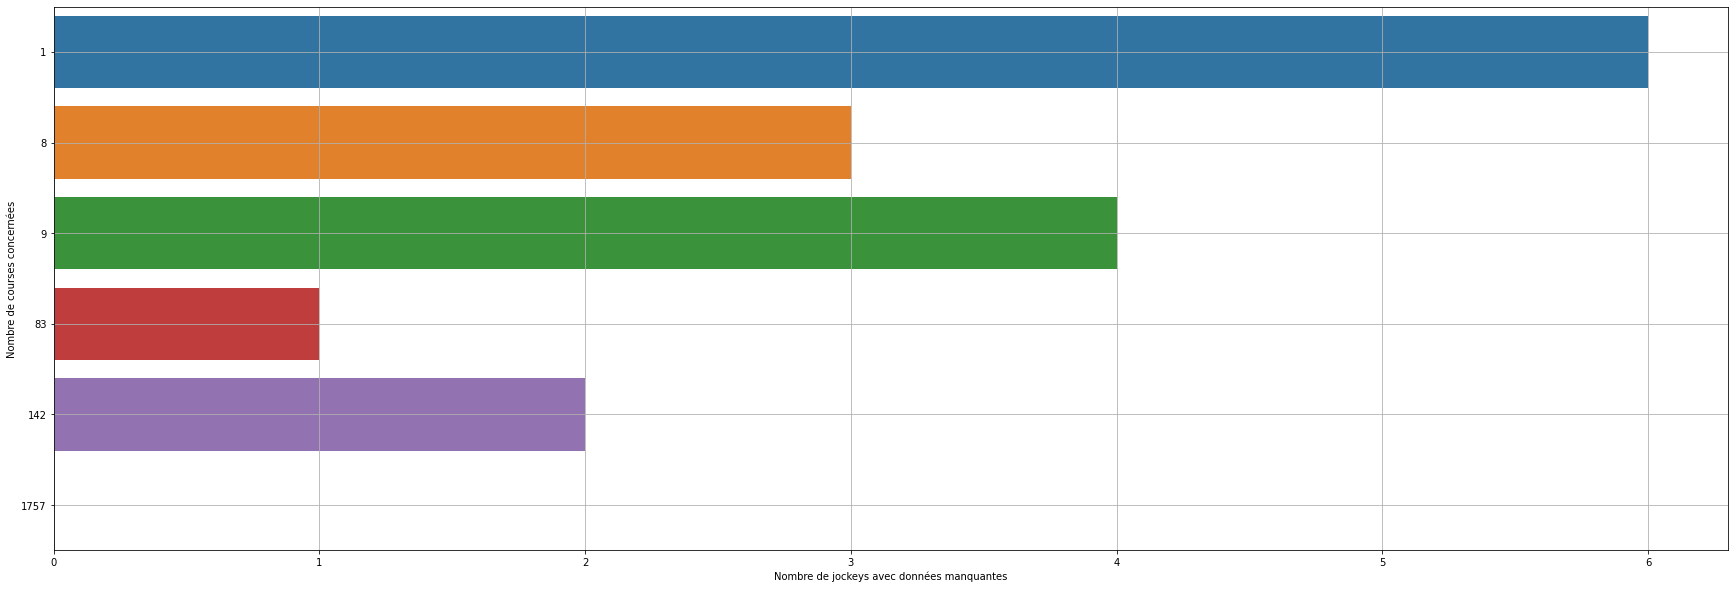

In [ ]:
df_tmp = data.drop_duplicates(subset = ["ID"]).copy()

df_tmp["missings"] = df_tmp.nb_trakus_ids != df_tmp.nb_max_trakus

df_tmp = df_tmp.groupby(["race_id", "missings"], as_index = False).jockey.count()

df_tmp.jockey = df_tmp.jockey * df_tmp.missings

df_tmp.sort_values(by = "missings", ascending = False, inplace = True)
df_tmp.drop_duplicates(subset = "race_id", inplace = True)

df_tmp = df_tmp.groupby("jockey", as_index = False).race_id.count()

df_tmp.columns = ["Nombre de jockeys avec données manquantes", "Nombre de courses concernées"]

plt.figure(figsize = (30, 10))
sb.barplot(data = df_tmp,
           y = "Nombre de courses concernées",
           x = "Nombre de jockeys avec données manquantes",
           orient = "h")
plt.grid()
plt.show()

In [ ]:
df = data[data.nb_trakus_ids == data.nb_max_trakus].copy()

df.derivee_distance_from_center = get_savgol_filter(df.derivee_distance_from_center, 2, 25)

# Approximation du moment où le jockey est à l'une des positions extrêmes de la piste
df["extremite"] = df.groupby("ID").derivee_distance_from_center.transform(lambda s: (s >= 0) & (s.shift(-1) < 0))

df["derivee_nulle"] = df.groupby("ID").derivee_distance_from_center.transform(lambda s: ((s >= 0) & (s.shift(-1) < 0)) | \
                                                                                        ((s <= 0) & (s.shift(-1) > 0)))


def assign_value(s):
  
  s.iloc[0] = True
  s.iloc[-1] = True

  return s

# Moments où la dérivée de la distance par rapport au centre s'annule (qu'on appellera position caractéristique)
df["pos_car"] = df.groupby("ID").derivee_nulle.transform(assign_value)

# Calcul des intervalles caractéristiques
def intervals_car(s):

  intervals = []
  for i in range(s.shape[0] - 1):

    if i!= 0:
      intervals.append([s.iloc[i] + 1, s.iloc[i+1]])
    else:
      intervals.append([s.iloc[i], s.iloc[i+1]])
  
  return intervals

# Calcul des vitesses moyennes caractéristiques
def get_mean_speed_intervals(df):
  
  means = []
  intervals = df["intervals_car"].iloc[0]

  for interval in intervals:
    means.append(df[df.trakus_index.between(*interval)].vitesse_kmh.mean().round(1))

  return means 

# Calcul des orientations caractéristiques
def get_mean_angle_intervals(df):
  
  means = []
  intervals = df["intervals_car"].iloc[0]

  for interval in intervals:
    means.append(df[df.trakus_index.between(*interval)].angle_deg.mean().round(1))

  return means 

# Distance entre deux points caractéristiques
def get_distance_intervals(df):
  
  distances = []
  intervals = df["intervals_car"].iloc[0]

  for interval in intervals:
    d = df[df.trakus_index.between(*interval)].distance_parcourue_m.iloc[[0,-1]].round(1)
    distances.append(round(d.iloc[1] - d.iloc[0], 1))

  return distances 

# Temps écoulé entre deux points caractéristiques
def get_time_intervals(df):
  
  intervals = df["intervals_car"].iloc[0]
  times = []

  for interval in intervals:
    times.append(.25 * (interval[1] - interval[0]))

  return times 

# Jeu de données filtrés sur les positions caractéristiques uniquement
df_intervals_car = df[df.pos_car].groupby("ID").trakus_index.apply(intervals_car).to_frame("intervals_car")
df = df.join(df_intervals_car, on = "ID")

# Ajout des différents résultats
df_tmp = df.groupby("ID").apply(get_time_intervals).to_frame("time_intervals")
df_tmp["mean_speed_intervals"] = df.groupby("ID").apply(get_mean_speed_intervals)
df_tmp["mean_angle_intervals"] = df.groupby("ID").apply(get_mean_angle_intervals)
df = df.join(df_tmp, on = "ID")

# Calcul de la corrélation entre les différentes positions des jockey durant les dix dernières secondes de la course
df_corr = df[df.trakus_index >= df.nb_max_trakus - 40].groupby("race_id")[["latitude", "longitude"]].corr().unstack().iloc[:,[1]]
df_corr.columns = ["corr_last_10s"]
df_corr.corr_last_10s = df_corr.corr_last_10s.abs()

# On filtre sur les corrélations supérieures à 0.6 
df = df.join(df_corr, on = "race_id")
df = df[df.corr_last_10s > .6]

df.shape

(1183709, 49)

In [ ]:
df_race = df[df.race_id == 159].copy() # 712, 400

In [ ]:
x_mean, y_mean = tuple(df_race[df_race.track_id == df_race.track_id.iloc[0]][["latitude", "longitude"]].mean().values)
x, y = "latitude", "longitude"

fig = \
px.scatter_mapbox(df_race.sort_values('trakus_index'), 
            lat = x, 
            lon = y, 
            hover_data = ["vitesse_kmh", "distance_parcourue_m", "angle_deg"],
            animation_frame = "temps", 
            animation_group = "jockey",
            color = "jockey",
            mapbox_style = "open-street-map",
            height = 800,
            center = {"lat" : x_mean, "lon" : y_mean},
            zoom = 15,
            title = "Course {} ayant prise place à {} le {}, type de course : {}, terrain : {}, conditions : {}".format(df_race.race_number.iloc[0],
                                                                                                                        df_race.track_id.iloc[0],
                                                                                                                        df_race.race_date.iloc[0],
                                                                                                                        df_race.race_type.iloc[0],
                                                                                                                        df_race.course_type.iloc[0],
                                                                                                                        df_race.track_condition.iloc[0]))
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 250
fig.show()

Carlos J. Hernandez 52.79943502824859 (vitesse moyenne)
Dylan Davis 60.3723163841808 (vitesse moyenne)
Eric Cancel 59.26299435028248 (vitesse moyenne)
Harry Hernandez 59.625423728813566 (vitesse moyenne)
Hector Rafael Diaz Jr. 55.428248587570614 (vitesse moyenne)
Joey R. Martinez 61.74661016949151 (vitesse moyenne)
Luis R. Reyes 59.77683615819209 (vitesse moyenne)
Reylu Gutierrez 61.21807909604519 (vitesse moyenne)


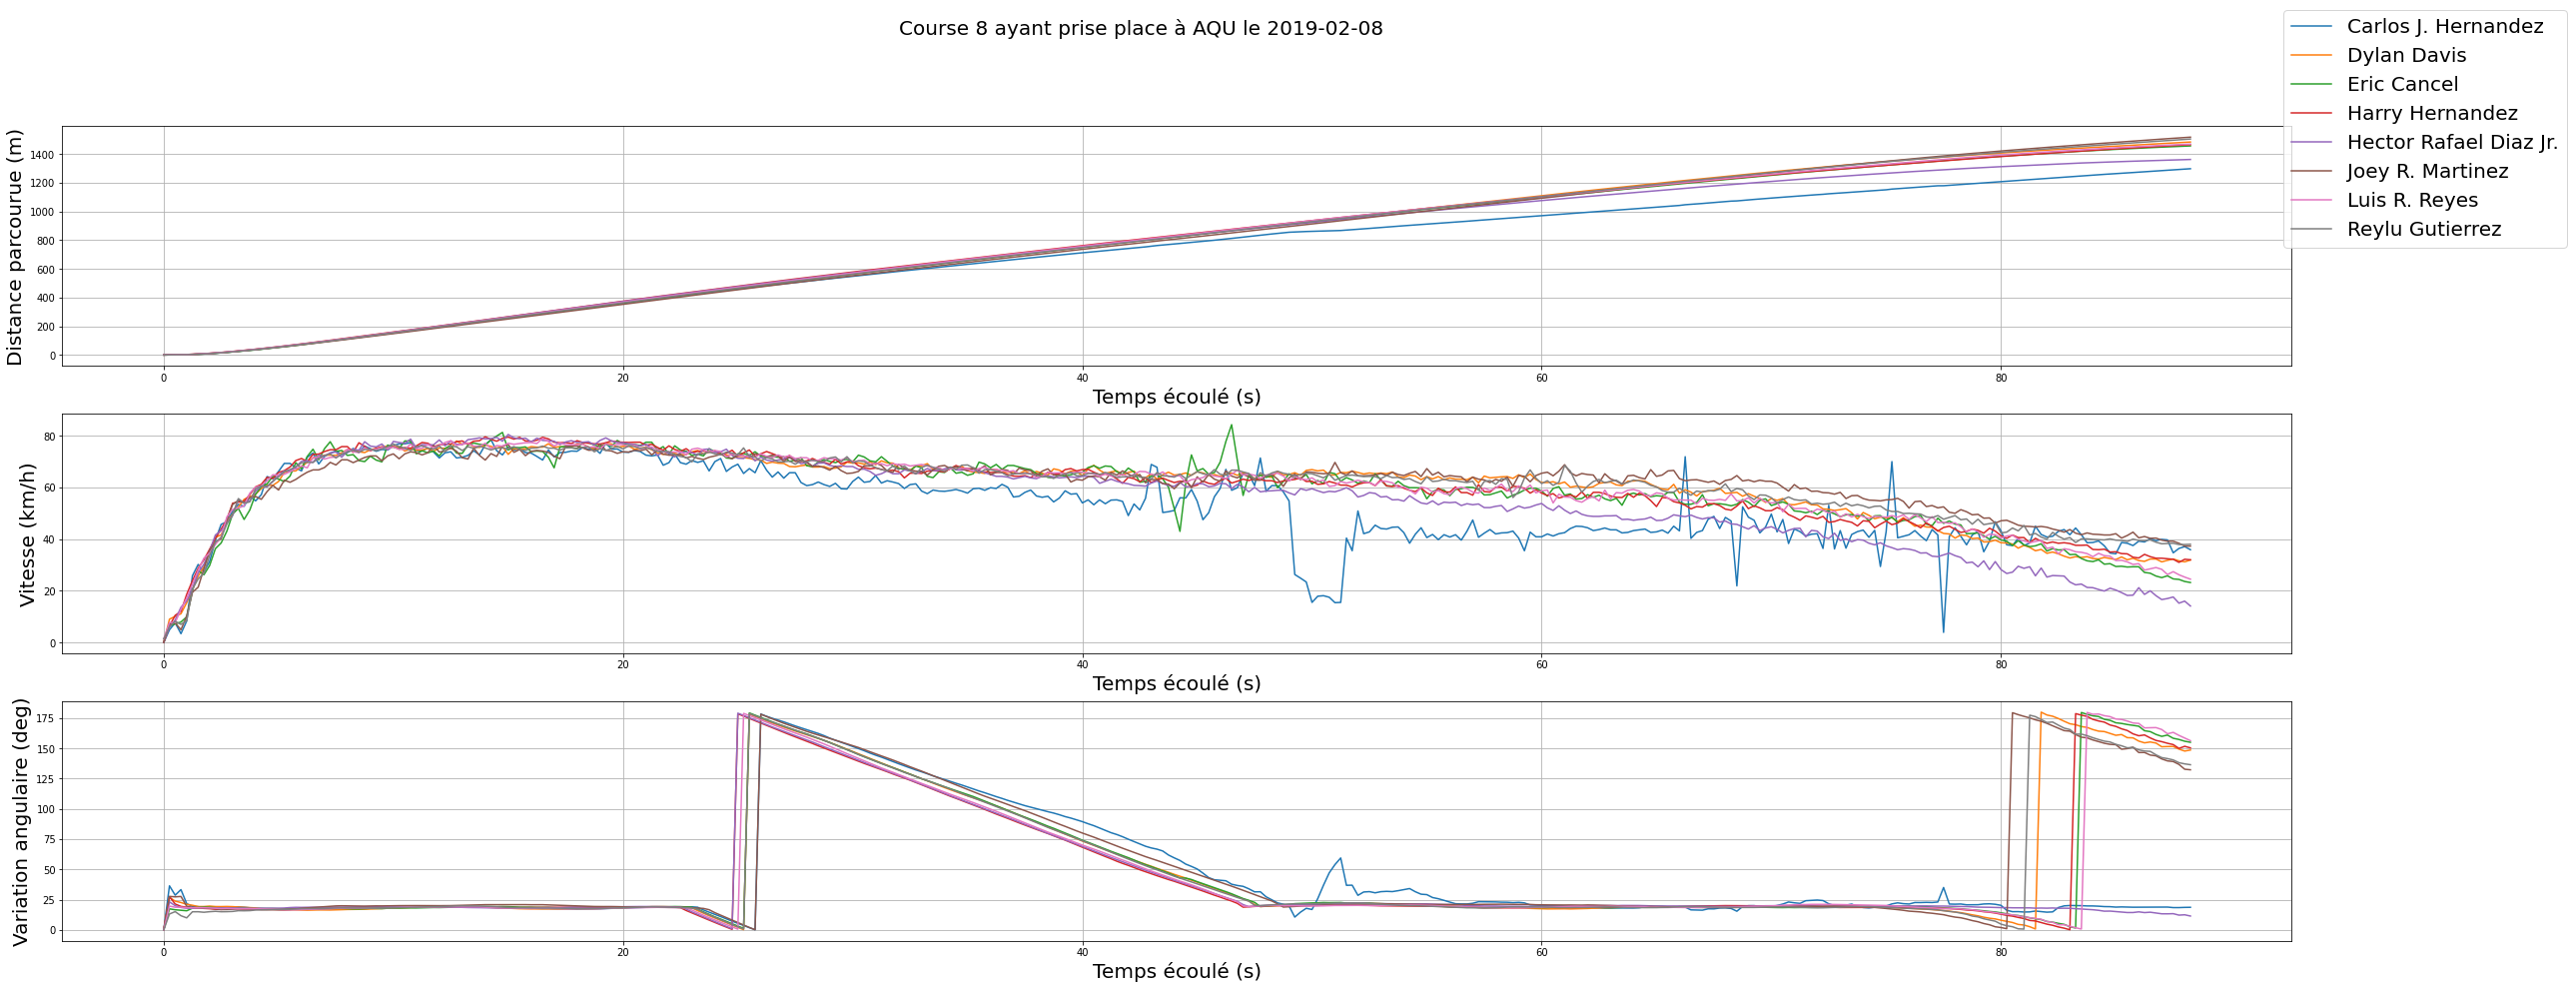

In [ ]:
first, last = "Jose Lezcano", "Samuel Jimenez"
first_vs_last = False

FONTSIZE = 20

fig, (ax1, ax2, ax4) = plt.subplots(3, figsize = (40, 15))
fig.suptitle("Course {} ayant prise place à {} le {}".format(df_race.race_number.iloc[0], df_race.track_id.iloc[0], df_race.race_date.iloc[0]),
             fontsize = FONTSIZE)

ax4.set_xlabel("Temps écoulé (s)", fontsize = FONTSIZE)
ax4.set_ylabel("Variation angulaire (deg)", fontsize = FONTSIZE)
ax4.grid()

ax1.set_xlabel("Temps écoulé (s)", fontsize = FONTSIZE)
ax1.set_ylabel("Distance parcourue (m)", fontsize = FONTSIZE)
ax1.grid()

ax2.set_xlabel("Temps écoulé (s)", fontsize = FONTSIZE)
ax2.set_ylabel("Vitesse (km/h)", fontsize = FONTSIZE)
ax2.grid()

for jockey, frame in df_race.groupby("jockey"):
  
  first_or_last = ""
  
  if first_vs_last:
   
    if jockey not in {first, last}:
      continue

    if jockey == first:
      first_or_last = " (first)"
   
    if jockey == last:
      first_or_last = " (last)"

  frame.sort_values(by = "trakus_index", inplace = True)

  ax4.plot(frame.secondes, frame.angle_deg, label = jockey + first_or_last)
  ax2.plot(frame.secondes, frame.vitesse_kmh)
  ax1.plot(frame.secondes, frame.distance_parcourue_m)

  print(jockey, frame.vitesse_kmh.mean(), "(vitesse moyenne)")

fig.legend(fontsize = FONTSIZE)
plt.show()

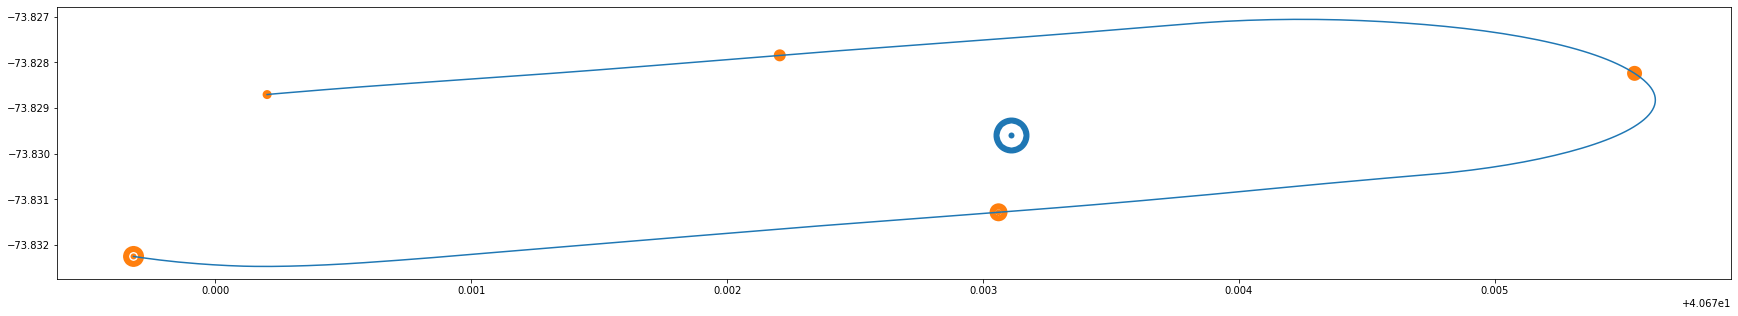

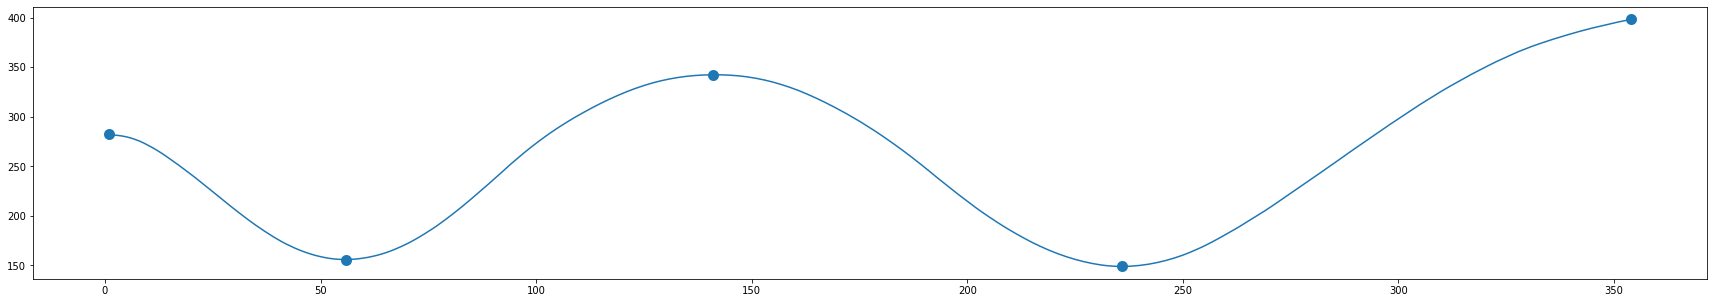

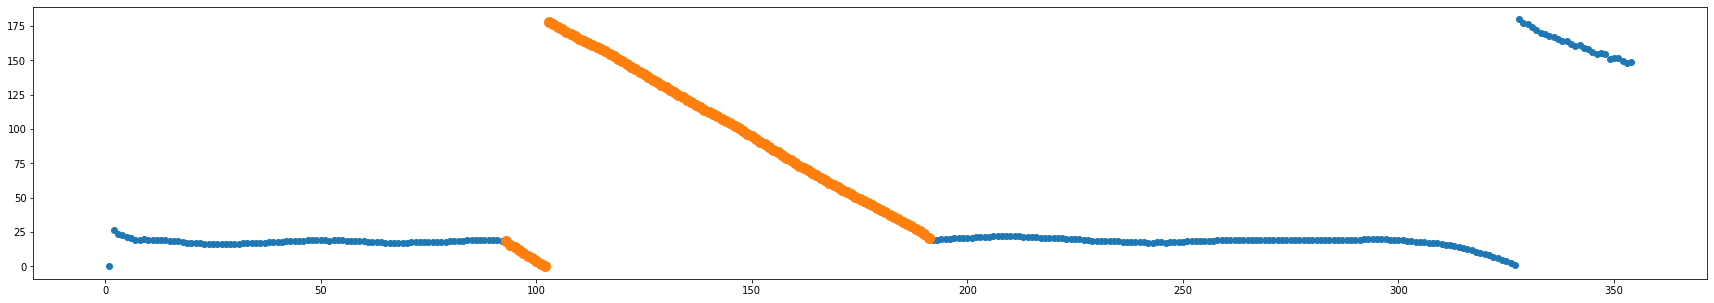

In [ ]:
import random

# On sélectionne aléatoirement un jockey ayant pris part à la course
df_tmp = df[df.ID == random.choice(df_race.ID.unique())].copy()

# Tracé de son parcours effectué
plt.figure(figsize = (30, 5))
plt.plot(df_tmp.latitude, df_tmp.longitude)
plt.scatter(df_tmp.lat_track_center.iloc[0], df_tmp.long_track_center.iloc[0], lw = 30)
plt.scatter(df_tmp[df_tmp.pos_car].latitude, df_tmp[df_tmp.pos_car].longitude, lw = 3 * (np.arange(df_tmp.pos_car.sum()) + 1))
plt.show()

# Tracé de la distance à laquelle il se trouve par rapport au centre de la piste à chaque moment
plt.figure(figsize = (30, 5))
plt.plot(df_tmp.trakus_index, df_tmp.distance_from_center_m)
plt.scatter(df_tmp[df_tmp.pos_car].trakus_index, df_tmp[df_tmp.pos_car].distance_from_center_m, lw = 5)
plt.show()

# Essai d'approximation du temps passé dans un virage par itérations successives
turns_trakus = []

for trakus_ext in df_tmp[df_tmp.extremite].trakus_index:

  turn_trakus = []

  df_iter_inf = df_tmp[df_tmp.trakus_index == trakus_ext].copy()
  df_iter_sup = df_iter_inf.copy()

  i = 0

  while(df_iter_inf.angle_deg.between(df_tmp.angle_deg.median() - 3, df_tmp.angle_deg.median() + 3).sum() == 0):  
    i += 1
    df_iter_inf = df_tmp[df_tmp.trakus_index.between(trakus_ext - i, trakus_ext)].copy()

  turn_trakus.append(trakus_ext - i)

  i = 0

  while((df_iter_sup.angle_deg.between(df_tmp.angle_deg.median() - 3, df_tmp.angle_deg.median() + 3).sum() == 0)):
    i += 1
    df_iter_sup = df_tmp[df_tmp.trakus_index.between(trakus_ext, trakus_ext + i)].copy()

  turn_trakus.append(trakus_ext + i)
  turns_trakus.append(turn_trakus)

plt.figure(figsize = (30, 5))
plt.scatter(df_tmp.trakus_index, df_tmp.angle_deg)
# plt.scatter(df_tmp.trakus_index, 0 * df_tmp.angle_deg + df_tmp.angle_deg.median())

for turn in turns_trakus:
  plt.scatter(df_tmp[df_tmp.trakus_index.between(*turn)].trakus_index,
          df_tmp[df_tmp.trakus_index.between(*turn)].angle_deg,
          lw = 5)

plt.show()

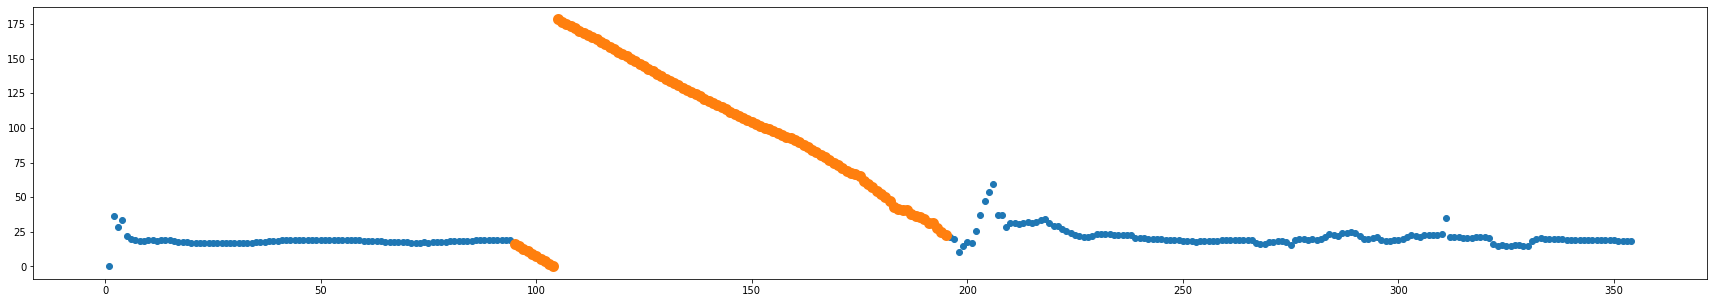

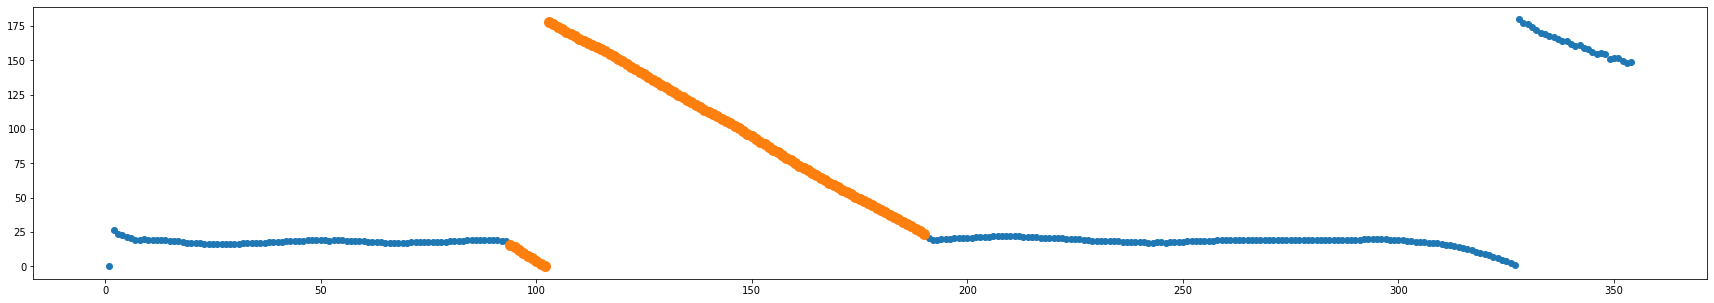

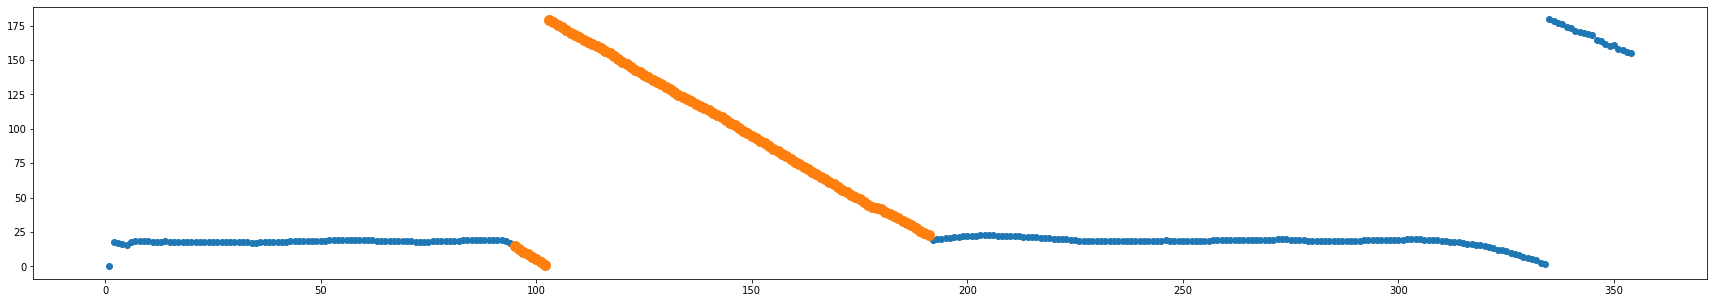

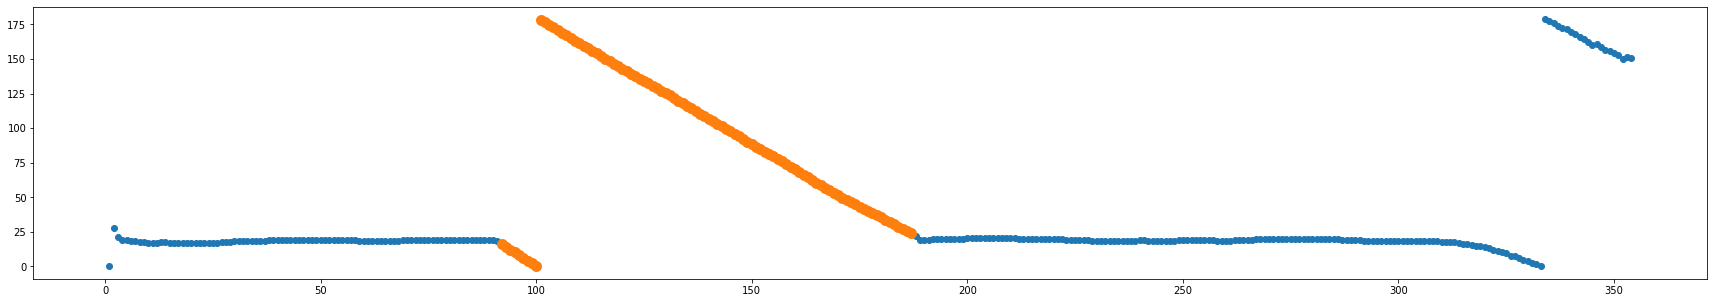

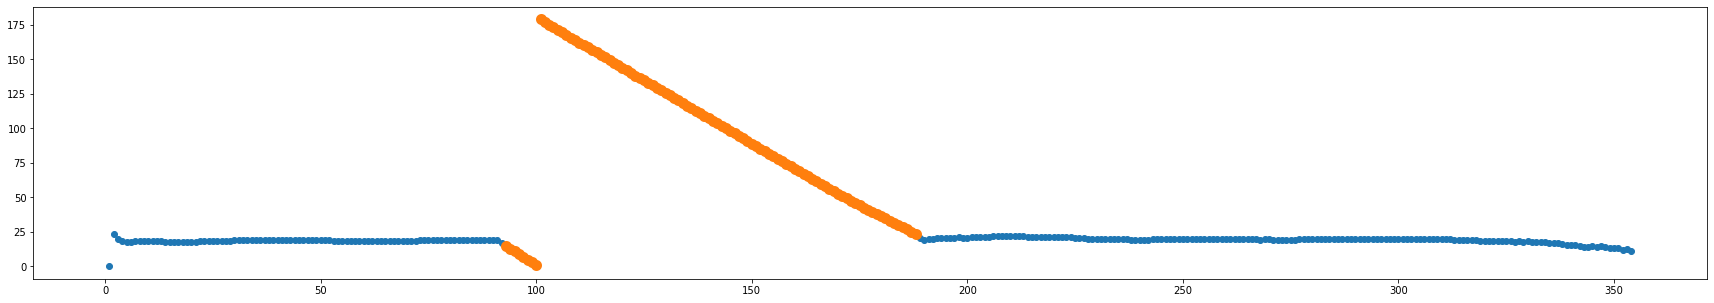

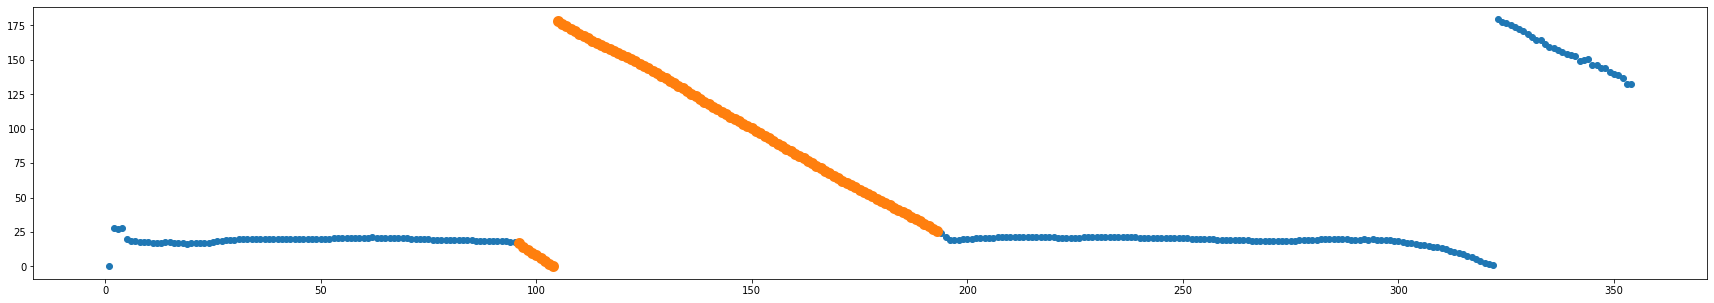

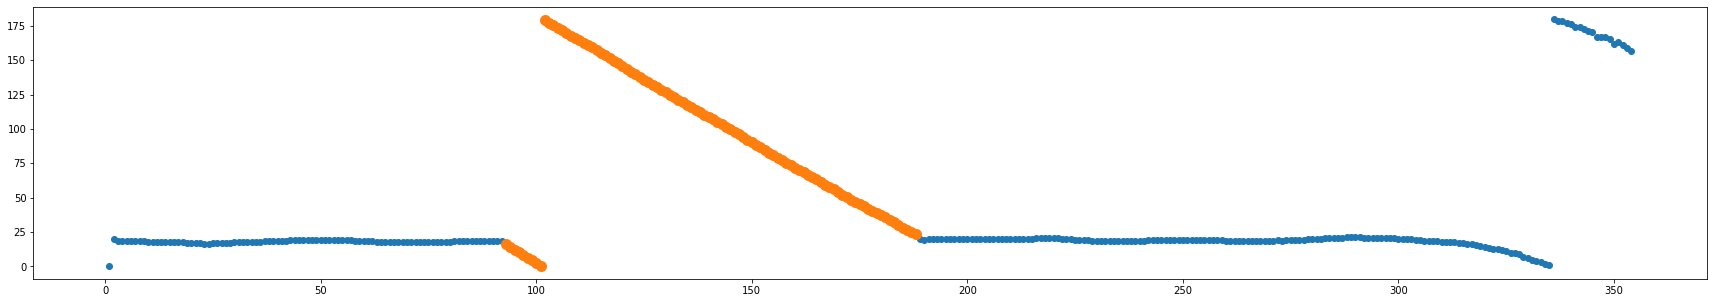

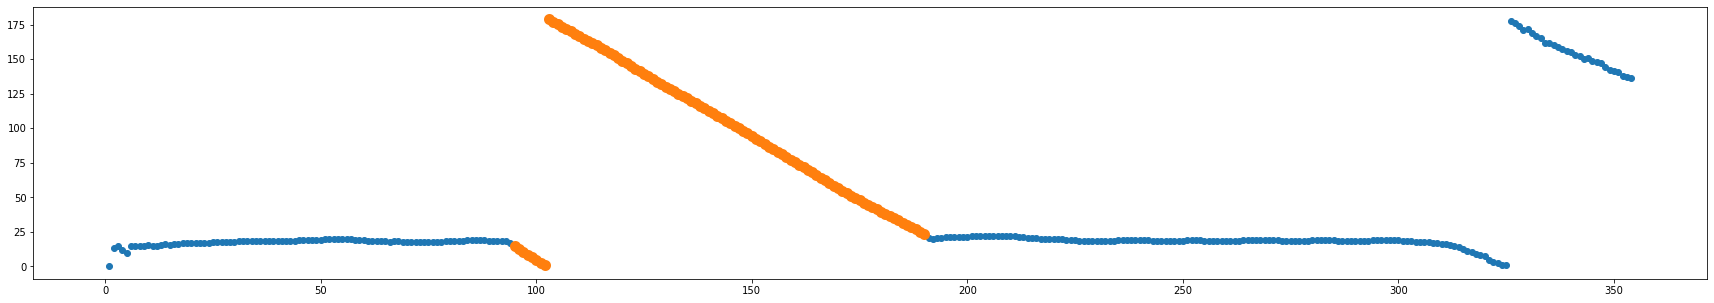

In [ ]:
# Mêmes actions que la cellule précédentes lors du calcul du temps passé dans le virage, cette fois-ci, pour tous les jockeys
for jockey, df_tmp in df_race.groupby("jockey"):

  turns_trakus = []

  for trakus_ext in df_tmp[df_tmp.extremite].trakus_index:

    turn_trakus = []

    df_iter_inf = df_tmp[df_tmp.trakus_index == trakus_ext].copy()
    df_iter_sup = df_iter_inf.copy()

    i = 0

    while(df_iter_inf.angle_deg.between(df_tmp.angle_deg.median() - 5, df_tmp.angle_deg.median() + 5).sum() == 0):  
      i += 1
      df_iter_inf = df_tmp[df_tmp.trakus_index.between(trakus_ext - i, trakus_ext)].copy()

    turn_trakus.append(trakus_ext - i)

    i = 0

    while((df_iter_sup.angle_deg.between(df_tmp.angle_deg.median() - 5, df_tmp.angle_deg.median() + 5).sum() == 0)):
      i += 1
      df_iter_sup = df_tmp[df_tmp.trakus_index.between(trakus_ext, trakus_ext + i)].copy()

    turn_trakus.append(trakus_ext + i)
    turns_trakus.append(turn_trakus)

  plt.figure(figsize = (30, 5))
  plt.scatter(df_tmp.trakus_index, df_tmp.angle_deg)
  # plt.scatter(df_tmp.trakus_index, 0 * df_tmp.angle_deg + df_tmp.angle_deg.median())

  for turn in turns_trakus:
    plt.scatter(df_tmp[df_tmp.trakus_index.between(*turn)].trakus_index,
            df_tmp[df_tmp.trakus_index.between(*turn)].angle_deg,
            lw = 5)

  plt.show()

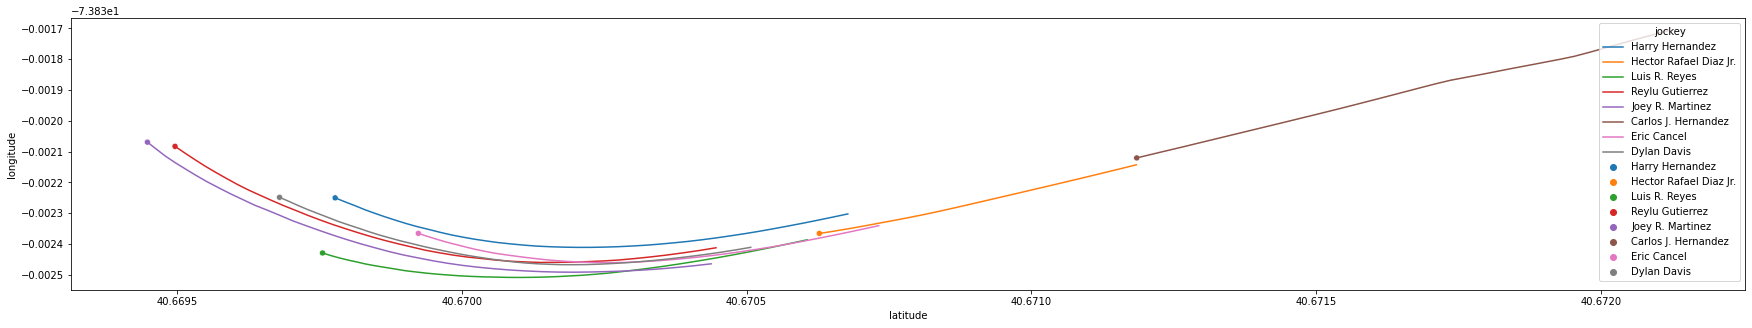

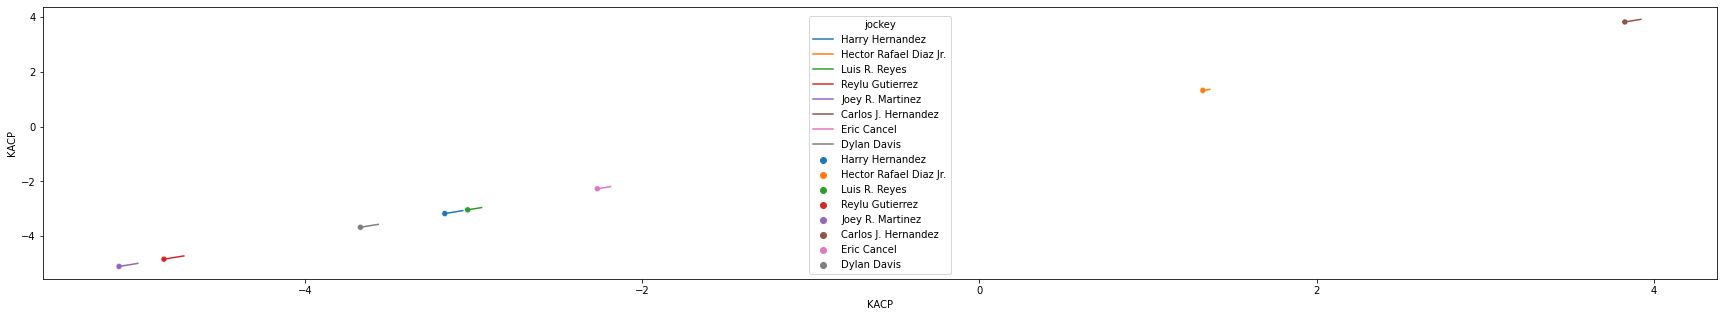

In [ ]:
# Essai de détermination du classement final de la course à partir des positions de chaque jockey lors des dix dernières secondes

df_last_10 = df_race[df_race.trakus_index >= df_race.nb_max_trakus - 40].copy()

# kernel polynomial car la course peut se terminer en plein virage
kacp = KernelPCA(n_components = 1, kernel = 'poly') 
df_last_10["KACP"] = kacp.fit_transform(df_last_10[["latitude", "longitude"]])

# Détermination du sens dans lequel se déplacent les jockeys
def get_sens(s):

  s = s.iloc[-1] - s.iloc[-2]
  s /= abs(s)
  return s

df_last_10["sens"] = df_last_10.groupby("jockey").KACP.transform(get_sens)

plt.figure(figsize = (30, 5))

sb.lineplot(data = df_last_10, 
            y = "longitude",
            x = "latitude",
            hue = "jockey")

sb.scatterplot(data = df_last_10[df_last_10.trakus_index == df_last_10.nb_max_trakus], 
            y = "longitude",
            x = "latitude",
            hue = "jockey")

plt.show()


# Affichage du résulat du KACP
plt.figure(figsize = (30, 5))

sb.lineplot(data = df_last_10[df_last_10.trakus_index >= df_last_10.nb_max_trakus - 1], 
            x = "KACP",
            y = "KACP",
            hue = "jockey")

sb.scatterplot(data = df_last_10[df_last_10.trakus_index == df_last_10.nb_max_trakus], 
            x = "KACP",
            y = "KACP",
            hue = "jockey")

plt.show()

In [ ]:
# Ajout d'un tableau final récapitulatif
df_last = df_last_10[df_last_10.trakus_index == df_last_10.nb_max_trakus].copy()


if df_last["sens"].value_counts().index[0] == 1:
  
  if df_last.corr_last_10s.iloc[0] > .8:
    df_last.sort_values(by = "latitude", ascending = False, inplace = True)

  else:
    df_last.sort_values(by = "KACP", ascending = False, inplace = True)
  
  df_last["classement"] = np.arange(len(df_last)) + 1

else:

  if df_last.corr_last_10s.iloc[0] > .8:
    df_last.sort_values(by = "latitude", inplace = True)

  else:
    df_last.sort_values(by = "KACP", inplace = True)
  
  df_last["classement"] = np.arange(len(df_last)) + 1

df_last = df_last[["ID", "jockey", "program_number", "classement", 
                   "odds", 'mean_speed_intervals', "mean_angle_intervals",
                   "vitesse_kmh"]].sort_values(by = "classement")

df_last.rename(inplace = True, columns = {"vitesse_kmh" : "derniere_vitesse"})

df_mean_speed = df_race.groupby("jockey")[["vitesse_kmh"]].mean().round()
df_mean_speed.columns = ["vitesse_moyenne"]
df_last = df_last.join(df_mean_speed, on = "jockey")

df_mean_speed_last_10s = df_last_10.groupby("jockey")[["vitesse_kmh"]].mean().round()
df_mean_speed_last_10s.columns = ["vitesse_moyenne_last_10s"]
df_last = df_last.join(df_mean_speed_last_10s, on = "jockey")

df_last

,ID,jockey,program_number,classement,odds,mean_speed_intervals,mean_angle_intervals,derniere_vitesse,vitesse_moyenne,vitesse_moyenne_last_10s
4147382,1153,Joey R. Martinez,5,1,710,"[58.1, 71.0, 64.3, 54.5]","[19.0, 76.2, 44.8, 55.6]",37.3,62.0,43.0
3610320,1152,Reylu Gutierrez,1A,2,140,"[59.9, 71.9, 64.3, 51.6]","[17.0, 75.8, 42.7, 51.1]",38.0,61.0,41.0
3101951,1156,Dylan Davis,9,3,205,"[60.3, 71.9, 65.1, 48.3]","[18.1, 75.2, 43.8, 50.1]",31.9,60.0,35.0
2617140,1148,Harry Hernandez,1,4,140,"[61.4, 73.3, 62.5, 46.8]","[18.1, 75.1, 42.5, 43.2]",32.0,60.0,37.0
3434185,1151,Luis R. Reyes,7,5,3800,"[60.4, 73.1, 63.3, 47.1]","[17.8, 74.3, 42.8, 41.9]",24.5,60.0,35.0
3465753,1155,Eric Cancel,8,6,1100,"[59.3, 72.4, 63.4, 46.0]","[17.6, 76.1, 42.6, 43.3]",23.2,59.0,34.0
3843176,1149,Hector Rafael Diaz Jr.,3,7,600,"[60.8, 72.8, 59.4, 36.6]","[18.4, 75.5, 42.6, 18.6]",14.1,55.0,24.0
2518333,1154,Carlos J. Hernandez,6,8,2000,"[59.6, 67.2, 47.0, 40.9]","[18.8, 75.1, 40.8, 20.1]",35.9,53.0,40.0


In [ ]:
# Tableau des différents moments caractéristiques
nb_intervals = len(df_last.mean_speed_intervals.iloc[0])

df_intervals_race = df_last[["classement"]].reset_index(drop = True).copy()

df_intervals_race = pd.concat([df_intervals_race, 
                               pd.DataFrame(df_last.mean_speed_intervals.tolist(), 
                                            columns = ["mean_speed_interval_{}".format(i+1) for i in range(nb_intervals)])],
                              axis = 1)

df_intervals_race = pd.concat([df_intervals_race, 
                               pd.DataFrame(df_last.mean_angle_intervals.tolist(), 
                                            columns = ["mean_angle_interval_{}".format(i+1) for i in range(nb_intervals)])],
                               axis = 1)

df_intervals_race.head(1)

,classement,mean_speed_interval_1,mean_speed_interval_2,mean_speed_interval_3,mean_speed_interval_4,mean_angle_interval_1,mean_angle_interval_2,mean_angle_interval_3,mean_angle_interval_4
0,1,58.1,71.0,64.3,54.5,19.0,76.2,44.8,55.6


In [ ]:
# Analyse des différentes corrélations pour émettre des conclusions
df_corr = \
pd.concat([df_last.corr()[["classement"]].iloc[2:],
           df_intervals_race.corr()[["classement"]].iloc[1:]])

df_corr["classement_tmp"] = df_corr.classement.abs()
df_corr.sort_values(by = "classement_tmp", ascending = False, inplace = True)
df_corr.drop(columns = ["classement_tmp"], inplace = True)

df_corr

,classement
mean_speed_interval_4,-0.912785
mean_angle_interval_4,-0.910140
vitesse_moyenne,-0.901498
mean_angle_interval_3,-0.809971
mean_speed_interval_3,-0.731088
derniere_vitesse,-0.569038
vitesse_moyenne_last_10s,-0.551788
odds,0.408475
mean_angle_interval_2,-0.340947
mean_speed_interval_1,0.318164


In [ ]:
# Corrélation entre les cotes et les vitesses moyennes lors de la course
df_vitesse_moy_odd = data[["ID", "vitesse_kmh", "odds"]].copy()
df_vitesse_moy_odd = df_vitesse_moy_odd.groupby("ID").agg({
    "vitesse_kmh" : "mean",
    "odds" : "first"
})

df_vitesse_moy_odd.corr()

,vitesse_kmh,odds
vitesse_kmh,1.000000,-0.060006
odds,-0.060006,1.000000
